In [1]:
import pandas as pd
import numpy as np
import lib_tools as pt # Import Project Tools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import date, datetime

start_year = 2005
end_year = 2021

# load data into dictionnaries
dic_usagers = pt.load_usagers(start_year, end_year)
dic_caract  = pt.load_caract(start_year, end_year)
dic_vehic   = pt.load_vehicules(start_year, end_year)
dic_lieux   = pt.load_lieux(start_year, end_year)

### Preprocessings pour la construction de : df_usagers, df_caract, df_vehic, df_lieux

In [2]:
chk = False
df_usagers = pt.preproc_usagers(dic_usagers, chk)
df_caract = pt.preproc_caract(dic_caract, chk)
df_vehic = pt.preproc_vehic(dic_vehic, chk)
df_lieux = pt.preproc_lieux(dic_lieux, chk)

### Merge dans un seul DataFrame

In [3]:
df_all = pt.merge_dataframes(df_usagers=df_usagers, df_caract=df_caract, df_vehic=df_vehic, df_lieux=df_lieux)

### Transformation des  -1 (non renseigné) en *Null*

In [4]:
cols = ['atm', 'col', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 
        'senc', 'obs', 'obsm', 'choc', 'manv', 'motor', 'trajet', 'secu1', 'secu2', 
        'secu3', 'locp', 'actp', 'etatp', 'place', 'lum', 'int', 'nbv']

df_all[cols] = df_all[cols].replace(to_replace=[-1, '-1', ' -1'], value=np.nan)

### Représentation graphique des *Null*

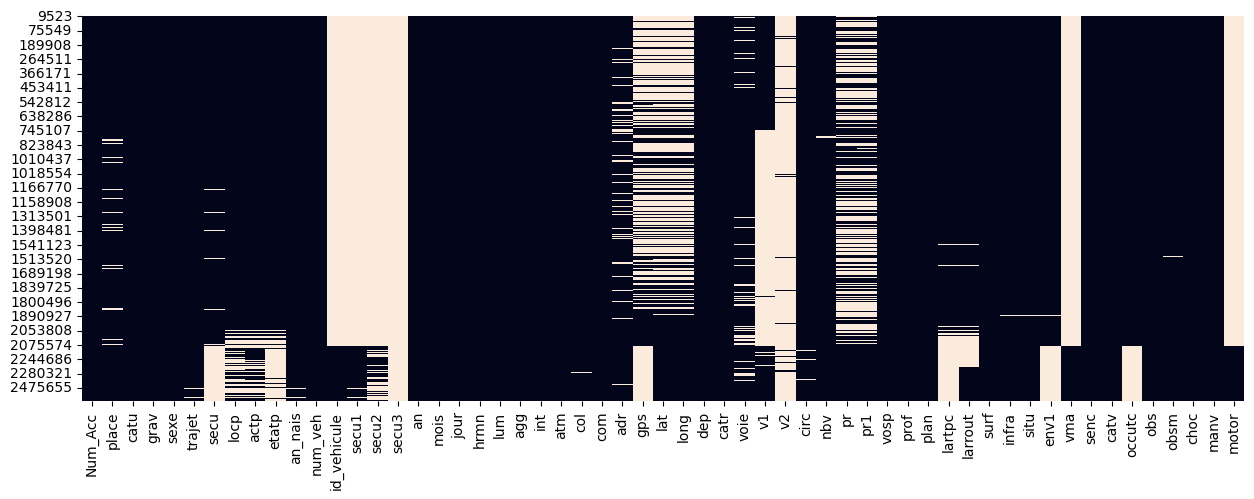

In [5]:
df_sample = df_all.sample(10000)
df_sample = df_sample.sort_values(by=['an', 'mois', 'jour'], ascending=True)

plt.figure(figsize=(15,5))
ax = sns.heatmap(df_sample.isna(), cbar=False);

### 1° suppression de variables

In [6]:
col_to_rmv = ['secu', 'secu1', 'secu2', 'secu3', 'id_vehicule', 'gps', 'pr', 'pr1', 'voie', 'v1', 'v2', 
               'lat', 'long', 'lartpc', 'larrout', 'env1', 'vma', 'occutc', 'motor', 'adr', 'locp', 'actp', 'etatp', 'com', 'dep']
print(f"{len(col_to_rmv)} colonnes à supprimer")

print(f"Dimensions du dataframe mergé avant suppression : {df_all.shape}")
df_all = df_all.drop(columns=col_to_rmv, axis=1, errors='ignore')
print(f"Dimensions du dataframe mergé après suppression : {df_all.shape}")

25 colonnes à supprimer
Dimensions du dataframe mergé avant suppression : (2506762, 57)
Dimensions du dataframe mergé après suppression : (2506762, 32)


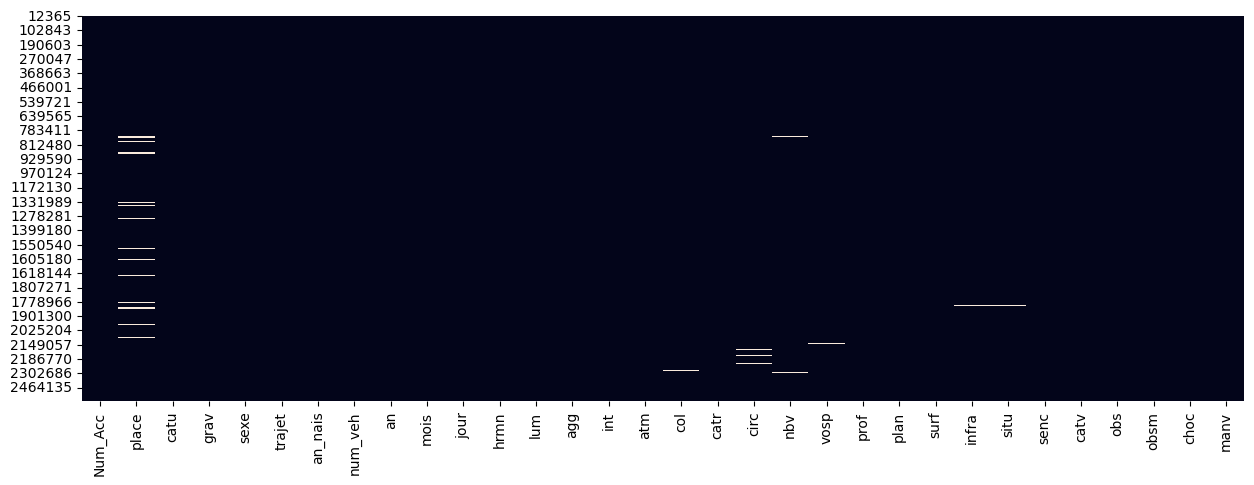

In [7]:
df_sample = df_all.sample(10000)
df_sample = df_sample.sort_values(by=['an', 'mois', 'jour'], ascending=True)

plt.figure(figsize=(15,5))
ax = sns.heatmap(df_sample.isna(), cbar=False);

### Remplacement des *Null* par les modalités les plus fréquentes

In [8]:
cols = df_all.columns[df_all.isnull().any()]

for col in cols:
    df_all = df_all.fillna(df_all[col].value_counts().index[0])
    
# todo : cf. mode()

In [9]:
# Lignes contenant au moins une valeur manquante
# df_all[df_all.isna().any(axis = 1)]

### Création et catégorisation de la variable *age*  - suppression de *an_nais*

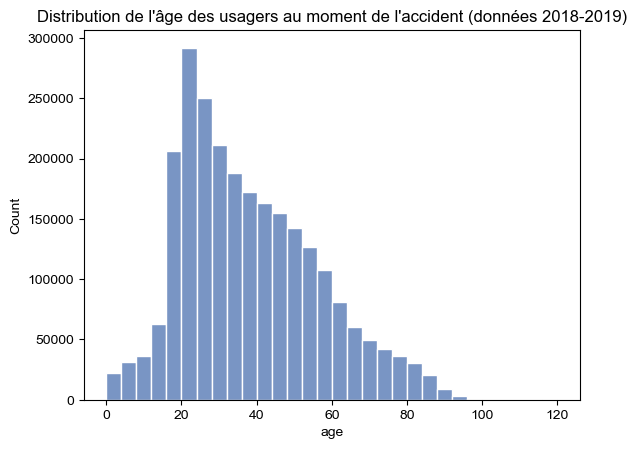

In [10]:
# Suppression des données aberrantes 
df_all['an_nais'].unique()

df_all = df_all.drop(df_all[df_all.an_nais == 1].index)

df_all = pt.create_col_age(df_all)
df_all = df_all.drop(columns=['an_nais'], axis=1)


df_all.age.unique()
df_all[df_all['age'] > 120]

plt.title("Distribution de l'âge des usagers au moment de l'accident (données 2018-2019)")
sns.set_theme(style="ticks")

# sns.histplot(data=df_all, x="age", hue="grav", multiple="stack", bins=30)
sns.histplot(data=df_all, x="age", bins=30);

###  Création de *date* - suppression de *an*, *mois*, *jour*

In [11]:
df_all = pt.create_col_date(df_all)

### Création de *joursem* (jour de la semaine)

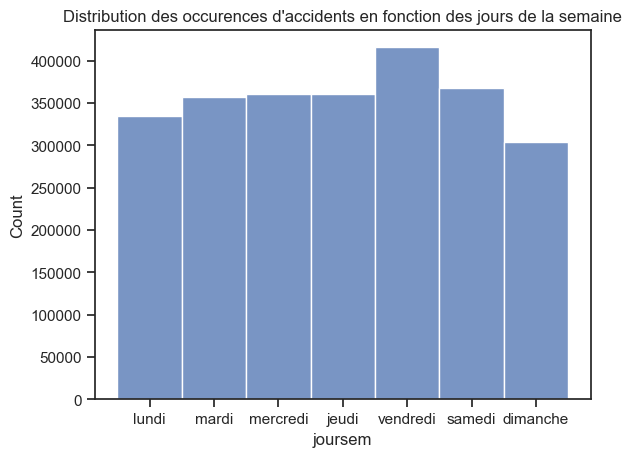

In [12]:
df_all = pt.create_col_joursem(df_all)

plt.title("Distribution des occurences d'accidents en fonction des jours de la semaine")
# sns.histplot(data=df_all, x="age", hue="grav", multiple="stack", bins=30)

df_tmp = df_all
df_tmp['joursem'] = pd.Categorical(df_all['joursem'], ['lundi','mardi','mercredi','jeudi', 'vendredi', 'samedi', 'dimanche'])

sns.set_theme(style="ticks")
sns.histplot(data=df_tmp, x="joursem");

### hrmn


In [13]:
def format_hour(s):
    if len(s) == 4:
        hr = s[0:2] if len(s[0:2]) == 2 else f"0{s[0:2]}"
        mn = s[3:4] if len(s[3:4]) == 2 else f"0{s[3:4]}"
        return datetime.strptime(f"{hr}:{mn}", "%H:%M").time() 

# Suppression des lignes avec heure = None
df_all['heure'] = [format_hour(str(h)) for h in df_all.hrmn]
df_all = df_all.drop(columns=['hrmn'], axis=1)

# df_all[df_all['heure'] == None]

# df_all = df_all.drop(df_all[df_all['heure'] == None].index)

# df_all['heure'].unique()
# stats_heure = df_all['heure'].value_counts()
# type(stats_heure)
# ax = sns.histplot(stats_heure, bins=300)
# ax.set_xlim(0,500)

# sns.histplot(df_all.heure);
# plt.hist(df_all.heure)

In [14]:
# for col in df_all.columns:
#     print(f"{col} : {len(df_all[col].unique())}")

# df_all[df_all.Num_Acc.isna()]

### Variables avec nombreuses modalités

place : ['1' '2' '4' '5' '3' '0' '8' '9' '7' '6' '10']
int : [1.0 2.0 9.0 0.0 6.0 8.0 3.0 4.0 7.0 5.0 '1']
atm : ['1' '2' '3' '8' '9' '7' '6' '4' '5']
catr : ['3' '2' '4' '6' '9' '5' '1' '7']
nbv : ['02' '00' '01' '03' '04' '06' '25' '05' '20' '07' '08' '30' '10' '40'
 '50' '12' '09' '27' '62' '60' '16' '26' '11' '21' '24' '29' '54' '39'
 '14' '84' '13' '18' '90' '15' '36' '65' '22' '42' '17' '99' '31' '53'
 '76' '70' '86' '91' '28' '45' '52' '33' '41' '44' '23' '1' '2' '8' '5'
 '3' '4' '6' '7' '0' '9']
surf : ['1' '2' '0' '9' '7' '8' '5' '6' '3' '4']
infra : ['0' '5' '4' '2' '3' '6' '1' '7' '9' '8']
situ : ['1' '5' '3' '4' '0' '2' '6' '8']
catv : <IntegerArray>
[ 7,  2,  9,  5, 18, 17,  1, 10,  4, 15, 19, 14, 13, 12, 21, 20, 99,  3, 16,
  8,  6, 11, 38, 32, 37, 30, 36, 31, 33, 39, 34, 35, 40, 42, 50, 80, 60,  0,
 43, 41, -1]
Length: 41, dtype: Int64
obs : <IntegerArray>
[0, 6, 8, 2, 1, 13, 3, 16, 11, 14, 7, 4, 5, 12, 15, 10, 9, 17]
Length: 18, dtype: Int64
choc : <IntegerArray>
[1, 8,

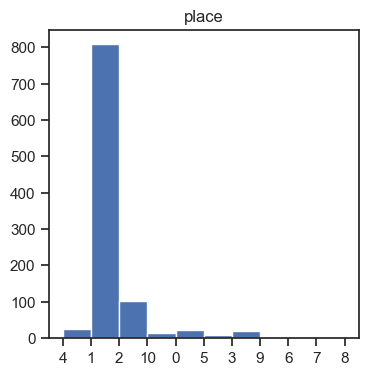

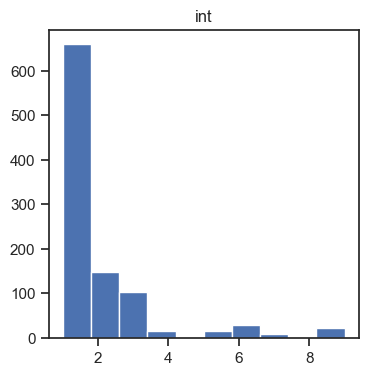

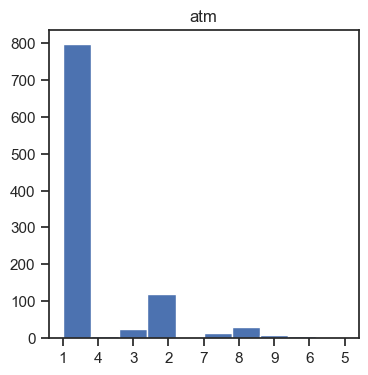

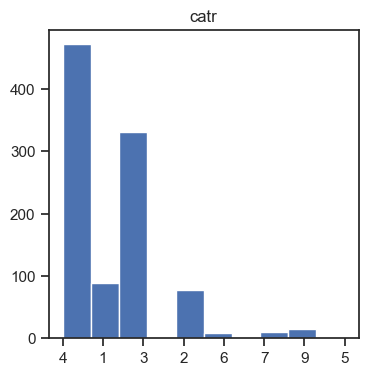

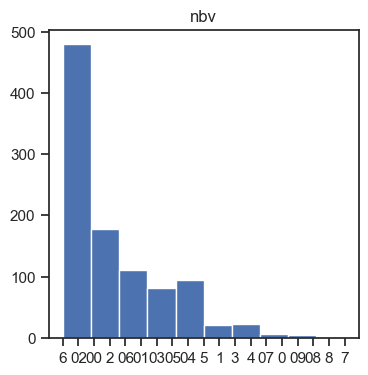

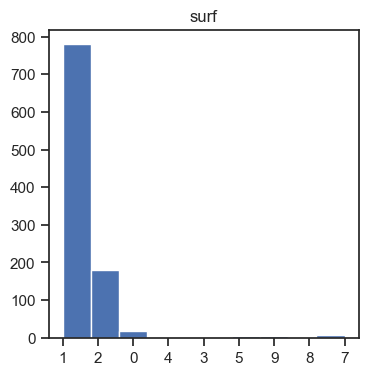

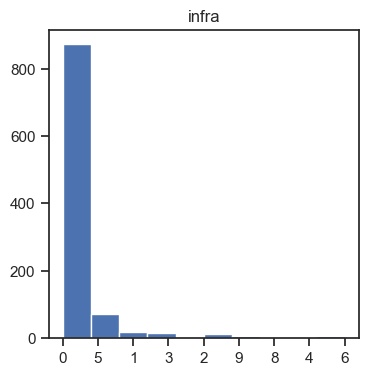

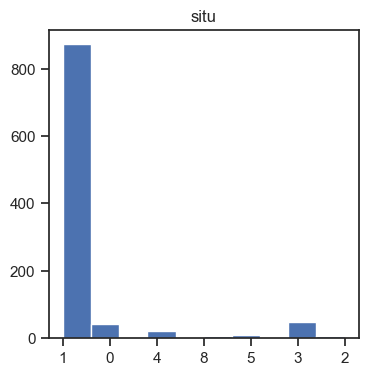

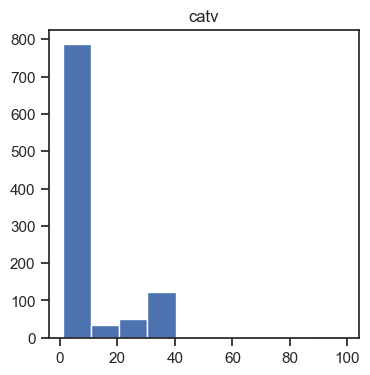

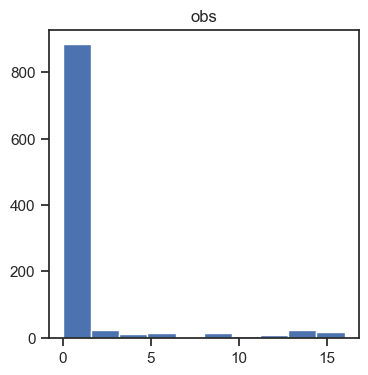

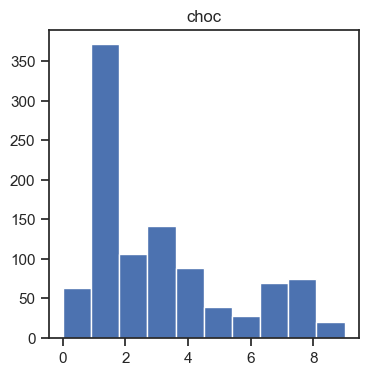

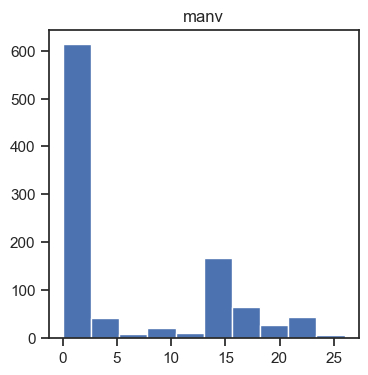

In [15]:
for col in df_all.columns:
    if not (col in ['Num_Acc', 'an_nais', 'num_veh', 'date', 'age', 'heure']):
        mods = df_all[col].unique()
        if len(mods) >= 8:
            print(f"{col} : {mods}")
            fig = plt.figure(figsize=(4,4))
            plt.title(col)
            plt.hist(df_all.sample(1000)[col])

### Volume des données

In [16]:
# nb de lignes et colonnes de chaque DataFrame

dic = {'caract' : dic_caract, 'lieux' : dic_lieux, 'usagers': dic_usagers, 'vehic' : dic_vehic}

for key in dic.keys() : 
    print(f"\n{key} : \n")
    nb_lin = []
    nb_col = []
   
    for year in range(start_year, end_year+1):
        dic_data = dic[key]
        df = dic_data[year]
        nb_lin.append(df.shape[0])
        nb_col.append(df.shape[1])
        print(f'{key} {year} : {df.shape[1]} colonnes x {df.shape[0]} lignes')

    print(f"\nnombre de lignes min : {min(nb_lin)}")    
    print(f"\nnombre de lignes max : {max(nb_lin)}")    


caract : 

caract 2005 : 16 colonnes x 87026 lignes
caract 2006 : 16 colonnes x 82993 lignes
caract 2007 : 16 colonnes x 83850 lignes
caract 2008 : 16 colonnes x 76767 lignes
caract 2009 : 16 colonnes x 74409 lignes
caract 2010 : 16 colonnes x 69379 lignes
caract 2011 : 16 colonnes x 66974 lignes
caract 2012 : 16 colonnes x 62250 lignes
caract 2013 : 16 colonnes x 58397 lignes
caract 2014 : 16 colonnes x 59854 lignes
caract 2015 : 16 colonnes x 58654 lignes
caract 2016 : 16 colonnes x 59432 lignes
caract 2017 : 16 colonnes x 60701 lignes
caract 2018 : 16 colonnes x 57783 lignes
caract 2019 : 15 colonnes x 58840 lignes
caract 2020 : 15 colonnes x 47744 lignes
caract 2021 : 15 colonnes x 56518 lignes

nombre de lignes min : 47744

nombre de lignes max : 87026

lieux : 

lieux 2005 : 18 colonnes x 87026 lignes
lieux 2006 : 18 colonnes x 82993 lignes
lieux 2007 : 18 colonnes x 83850 lignes
lieux 2008 : 18 colonnes x 76767 lignes
lieux 2009 : 18 colonnes x 74409 lignes
lieux 2010 : 18 colo

### Analyse intercorrelations between variables

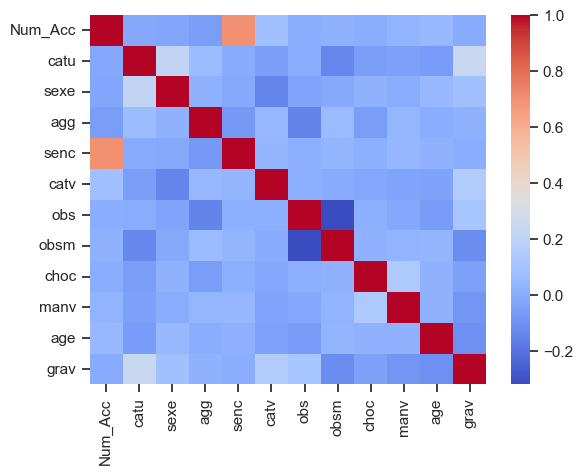

In [17]:
target = df_all['grav']
data = df_all.drop(columns=['grav'], axis=1)
# set 'grav' as last column of data
data['grav'] = target

# data = data.fillna(data.median())
# data_clean = data.dropna(how='any')

data_sample = data.sample(10000)
corr = data_sample.corr()

sns.heatmap(corr, annot=False, cmap='coolwarm');
# sns.clustermap(corr, annot=False, cmap='coolwarm');

### Evolution de gravité 'Blessé hospitalisé' en 2019?

In [18]:
df_usagers_2005 = df_all[df_all.an == 2005]
df_usagers_2021 = df_all[df_all.an == 2021]

# sns.histplot(df_usagers_2018.grav)
# ax = plt.hist([df_usagers_2018.grav, df_usagers_2019.grav], color=['r', 'b'], alpha=0.5)

print("\nDistribution de la variable gravité en 2005 : \n")
print(df_usagers_2018.grav.value_counts(normalize=True))

print("\nDistribution de la variable gravité en 2021 : \n")
print(df_usagers_2019.grav.value_counts(normalize=True))

AttributeError: 'DataFrame' object has no attribute 'an'